## 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

**내장 데이터 활용 : boston 데이터 셋**

In [4]:
# data_url = "http://lib.stat.cmu.edu/datasets/boston"
# raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
# data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
# target = raw_df.values[1::2, 2]

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
# from sklearn.datasets import load_boston
%matplotlib inline

In [2]:
# boston 데이타셋 로드
boston = load_boston()

In [9]:
# pandas 변수모양 그대로 저장할 때 사용하는 함수
bostonDF = pd.read_pickle('a.pkl')
# 저장된 pandas 객체 불러올 때
# pd.read_pickle('a.pkl')

In [12]:
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [14]:
# df 변환 후 내용 확인
# bostonDF = pd.DataFrame(boston.data, columns= boston.feature_names)
# bostonDF['PRICE'] = boston.target

# print('Boston 데이타셋 크기 :',bostonDF.shape)
# bostonDF.head()

# PRICE 예측해야 할 값
bostonDF.shape

(506, 14)

- CRIM: 지역별 범죄 발생률
- ZN: 25,000평방피트를 초과하는 거주 지역의 비율
- INDUS: 비상업 지역 넓이 비율
- CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
- NOX: 일산화질소 농도
- RM: 거주할 수 있는 방 개수
- AGE: 1940년 이전에 건축된 소유 주택의 비율
- DIS: 5개 주요 고용센터까지의 가중 거리
- RAD: 고속도로 접근 용이도
- TAX: 10,000달러당 재산세율
- PTRATIO: 지역의 교사와 학생 수 비율
- B: 지역의 흑인 거주 비율
- LSTAT: 하위 계층의 비율
- MEDV: 본인 소유의 주택 가격(중앙값)

In [15]:
## null 값 없고 모두 float
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


집 값에 크게 영향을 미치는 중요한 요소
- 삶의 편리도를 생각하면 :  RM 거주할 수 있는 방 개수
- RAD: 고속도로 접근 용이도 : 미국은 차가 있어야 하니까
- ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD'] 선정

Seaborn의 regplot() 이용 
- 각 ax마다 칼럼과 PRICE의 관계 표현
- 2차원 평면에서 X축을 피처, Y축을 타겟값으로 설정하면
- 산점도와 함께 선형 회귀 직선 표시

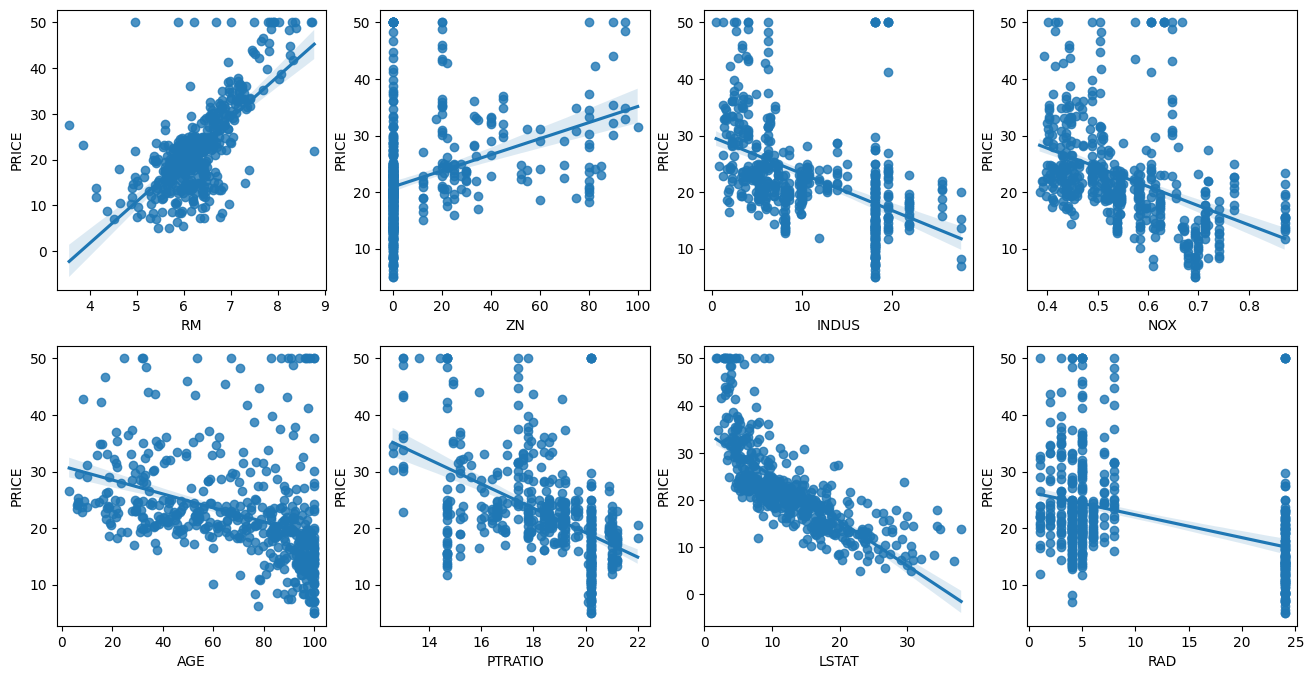

In [18]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,8) , ncols=4 , nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']

# 각 요소에 대해 시각화
for i , feature in enumerate(lm_features):
    row = int(i/4)
    col = i % 4
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

    

LinearRegression 클래스를 이용해서 보스턴 주택 가격의 회귀 모델 만들기
- train_test_split()을 이용해서 학습/테스트 데이터 세트 분리
- fit() 학습, predict() 예측 수행
- metrics 모듈의 mean_squared_error() 이용해서 MSE 측정
- r2_score() 이용해서 R2 Score 측정

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score

y_target = bostonDF['PRICE']
# 타겟 제외하고 피처 데이터 세트 만들기
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)
X_train , X_test , y_train , y_test = train_test_split(X_data , y_target ,test_size=0.3, random_state=156)

In [35]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test) # 테스트 데이터로 예측
mse = mean_squared_error(y_test, y_preds) # 실제값과 예측값의 차이를 제곱해서 평균한 평가지표
rmse = np.sqrt(mse) # rmse 계산 함수는 사이킷런이 지원하지 않기 때문에 np.sqrt(mse) 사용
r2 = r2_score(y_test, y_preds) # ls.score() 반환값과 같은 결과
print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297 , RMSE : 4.159
Variance score : 0.757


**회귀계수와 절편값 확인**

In [36]:
bostonDF.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'PRICE'],
      dtype='object')

In [37]:
print('절편 값 : ', lr.intercept_)
print('가중치 : ', np.round(lr.coef_, 1))

절편 값 :  40.99559517216444
가중치 :  [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [40]:
coeff =pd.Series(data=np.round(lr.coef_,1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

### 결과
- RM이 3.4로 회귀계수가 가장 큼
- 특이사항 : NOX 피처의 회귀계수 값이 너무 큼(NOX 때문에 예측 오류값이 달라 질 수 있음)

#### 교차검증(Cross Validation, CV)

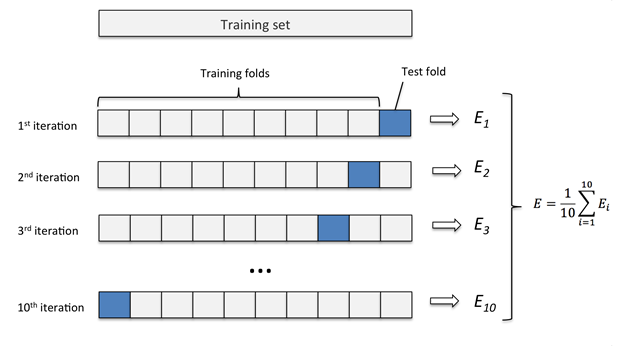

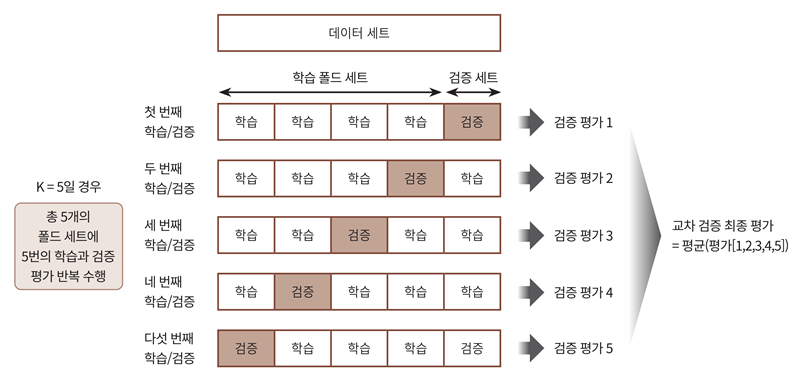

- 교차 검증 (Cross Validation) 과정
    1. 폴드 세트 설정
    2. for 문에서 반복적으로 학습 및 검증 데이터 추출 및 학습과 예측 수행
    3. 폴드 세트별로 예측 성능을 평균하여 최종 성능 평가

### cross_val_score( ) 함수
- 1 ~ 3 단계의 교차 검증 과정을 한꺼번에 수행
- 내부에서 Estimator를 학습(fit), 예측(predict), 평가(evaluation) 시켜주므로
- 간단하게 교차 검증 수행 가능

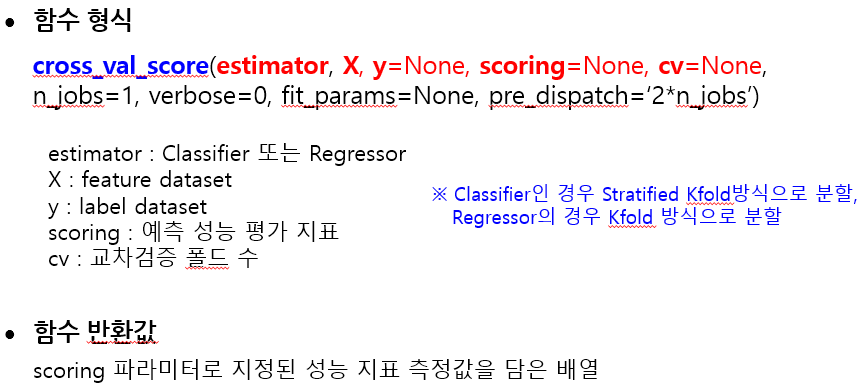

**MSE와 RMSE 측정**
- 5개의 폴드 세트에서 cross_val_score()를 이용해서 교차 검증 수행

Tip. MSE : 사이킷런에서 반환되는 값은  
- cross_val_score()의 인자로 scoring="neg_mean_squared_error" 하면
    - 음수값 반환
    
- 사이킷런의 지표 평가 기준은 높은 지표값일수록 좋은 모델인데 반해
    - 회귀는 MSE 값이 낮을수록 좋은 회귀 모델이므로

- 사이킷런의 metric 평가 기준에 MSE를 부합시키기 위해
    - 반환된 음수 값에 -1을 곱해서 양의 값으로 변환

In [41]:
# 5개의 폴드 세트에 교차 검증 수행
# MSE와 RMSE 측정

from sklearn.model_selection import cross_val_score

# 데이터가 504 관측치
# train/val/test 로 분리해야 하나 데이터가 크지 않아서 train/val
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)


In [44]:
# RMSE : neg-MSE에 -1  곱하고  sqrt()
neg_mse = cross_val_score(lr,X_data, y_target,
               scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1 *neg_mse)
avg_rmse = np.mean(rmse_scores)
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))


 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829 


- data에 대해서 특별한 전처리를 진행하지 않음
    - 전처리 후 성능확인
    
- 5 folds 의 평균 RMSE : 5.829의 의미는 이 data로 모델을 만들 때 rmse5.829 
- 이상의 성능을 기대할 수 있다.
     - 단 모든 데이터로 학습은 진행함. 실제는 test데이터를 분리하고도 검증이 가능할 정도의 데이터가 있어야 한다.